In [1]:
import warnings
warnings.simplefilter(action='ignore',)

from qiskit import QuantumCircuit, Aer
from qiskit.visualization import plot_histogram

import networkx as nx
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
def maxcut_obj(x, G):

    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            obj -= 1    

    return obj


def compute_expectation(counts, G):
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = maxcut_obj(bitstring, G)
        avg += obj * count
        sum_count += count
     
    return avg/sum_count


def create_qaoa_circ(G, theta):

    nqubits = len(G.nodes())
    p = len(theta)//2  
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]

    qc.h(range(nqubits))
    
    for irep in range(p):
        qc.barrier()
        for pair in list(G.edges()): qc.rzz(2 * gamma[irep], pair[0], pair[1])
        for i in range(0, nqubits): qc.rx(2 * beta[irep], i)
            
    qc.measure_all()
        
    return qc

def get_expectation(G, shots=1024):
    
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_qaoa_circ(G, theta)
        counts = backend.run(qc, seed_simulator=10, nshots=1024).result().get_counts()
        
        return compute_expectation(counts, G)
    
    return execute_circ

[[0 1 0 1]
 [1 0 1 0]
 [0 1 0 1]
 [1 0 1 0]]


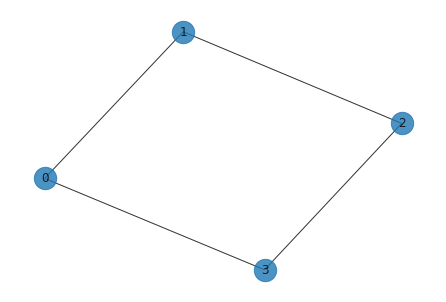

In [3]:
G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3])
G.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0)])

adjacency = nx.adjacency_matrix(G).todense()
print(adjacency)

nx.draw(G, with_labels=True, alpha=0.8, node_size=500)

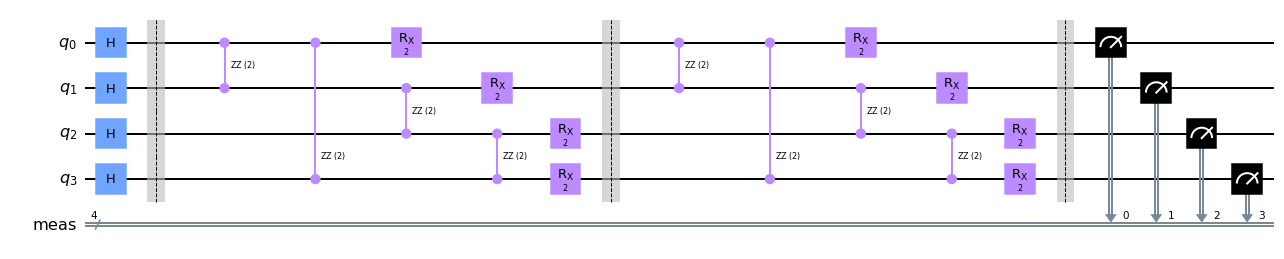

In [4]:
repeat = 2

initial_point = []
for i in range(2*repeat): initial_point.append(1.0)
create_qaoa_circ(G,initial_point).draw(output="mpl", fold=-1)

In [5]:
expectation = get_expectation(G)

res = minimize(expectation, 
                      initial_point, 
                      method='COBYLA')
res

     fun: -3.92578125
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 40
  status: 1
 success: True
       x: array([2.08522423, 2.1753362 , 1.00239937, 1.056763  ])

Top 2 solutions:
sol: 1010 , max cut: 4
sol: 0101 , max cut: 4

expect max cut: 4


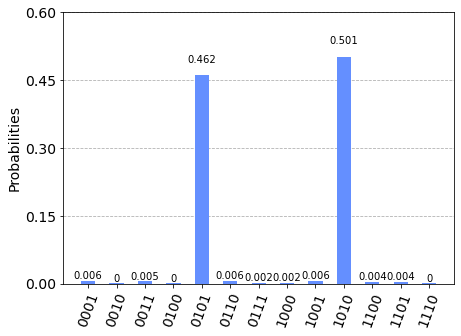

In [6]:
backend = Aer.get_backend('qasm_simulator')
backend.shots = 1024

qc_res = create_qaoa_circ(G, res.x)

counts = backend.run(qc_res, seed_simulator=10).result().get_counts()
sort = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))
print("Top 2 solutions:")
es = 0
for i in sort:
    print('sol:',i,', max cut:',-maxcut_obj(i,G))
    es+=1
    if es == 2: break
# plot_histogram(counts)

expect = []
for i in range(100): expect.append(nx.algorithms.approximation.maxcut.one_exchange(G)[0])
print('\nexpect max cut:', max(expect))
plot_histogram(counts)

[[0 1 0 0 0 1]
 [1 0 1 0 0 0]
 [0 1 0 1 0 0]
 [0 0 1 0 1 0]
 [0 0 0 1 0 1]
 [1 0 0 0 1 0]]


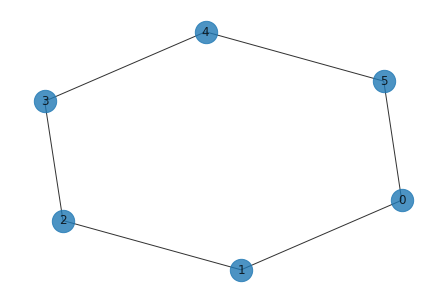

In [7]:
G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3, 4, 5])
G.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 0)])

adjacency = nx.adjacency_matrix(G).todense()
print(adjacency)

nx.draw(G, with_labels=True, alpha=0.8, node_size=500)

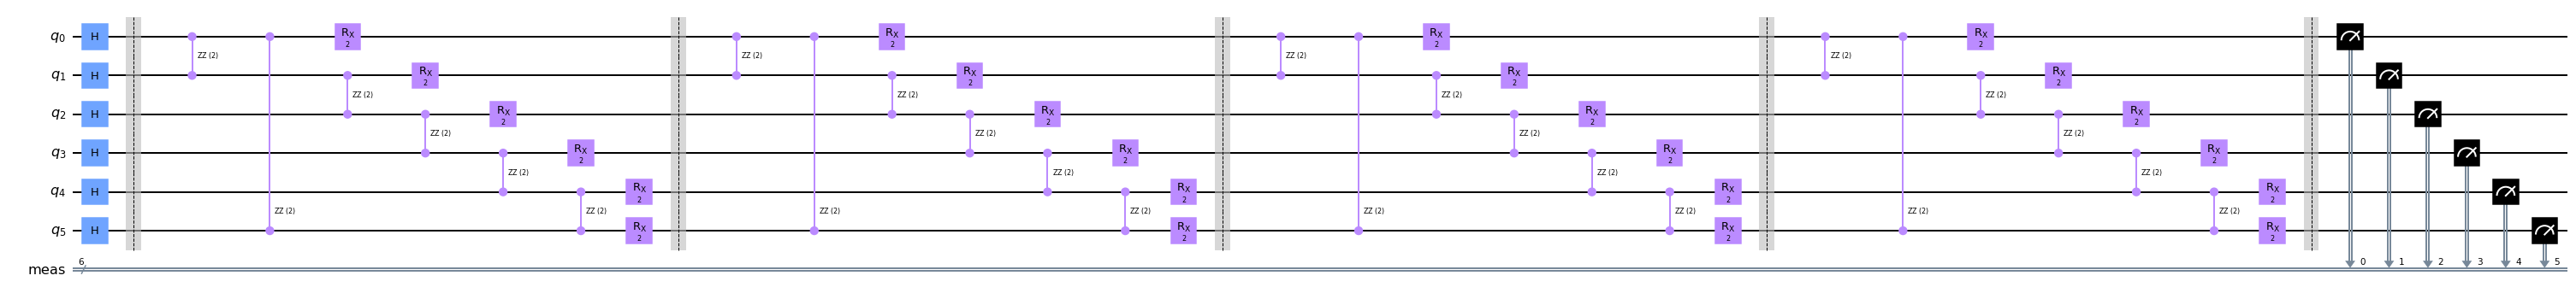

In [8]:
repeat = 4

initial_point = []
for i in range(2*repeat): initial_point.append(1.0)
create_qaoa_circ(G,initial_point).draw(output="mpl", fold=-1)

In [9]:
expectation = get_expectation(G)

res = minimize(expectation, 
                      initial_point, 
                      method='COBYLA')
res

     fun: -5.923828125
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 152
  status: 1
 success: True
       x: array([1.07615097, 1.9137945 , 2.00949648, 1.23292686, 2.38911617,
       1.03513721, 0.85160915, 0.93285944])

Top 2 solutions:
sol: 101010 , max cut: 6
sol: 010101 , max cut: 6

expect max cut: 6


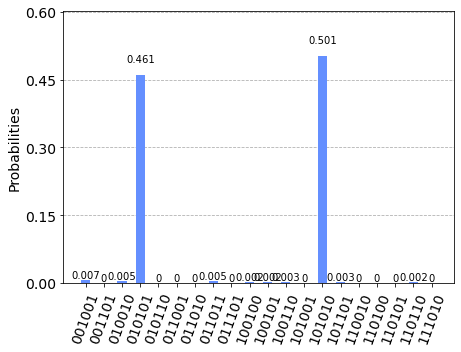

In [10]:
backend = Aer.get_backend('qasm_simulator')
backend.shots = 1024

qc_res = create_qaoa_circ(G, res.x)

counts = backend.run(qc_res, seed_simulator=10).result().get_counts()
sort = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))
print("Top 2 solutions:")
es = 0
for i in sort:
    print('sol:',i,', max cut:',-maxcut_obj(i,G))
    es+=1
    if es == 2: break
# plot_histogram(counts)

expect = []
for i in range(100): expect.append(nx.algorithms.approximation.maxcut.one_exchange(G)[0])
print('\nexpect max cut:', max(expect))
plot_histogram(counts)

[[0 0 1 0 0 0 1 1]
 [0 0 0 0 0 1 1 1]
 [1 0 0 1 0 1 1 1]
 [0 0 1 0 1 1 1 0]
 [0 0 0 1 0 1 0 0]
 [0 1 1 1 1 0 1 0]
 [1 1 1 1 0 1 0 1]
 [1 1 1 0 0 0 1 0]]


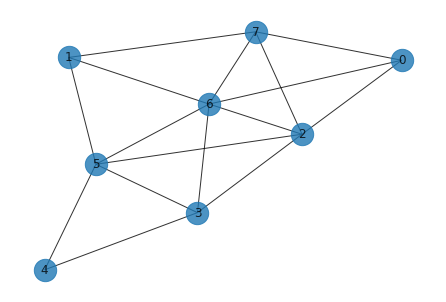

In [11]:
G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3, 4, 5, 6, 7])
G.add_edges_from([(0, 2), (0, 6), (0, 7), (1, 5), (1, 6), (1, 7), (2, 3), (2, 5), (2, 6), (2, 7), (3, 4), (3, 5), (3, 6), (4, 5), (5, 6), (6, 7)])

adjacency = nx.adjacency_matrix(G).todense()
print(adjacency)

nx.draw(G, with_labels=True, alpha=0.8, node_size=500)

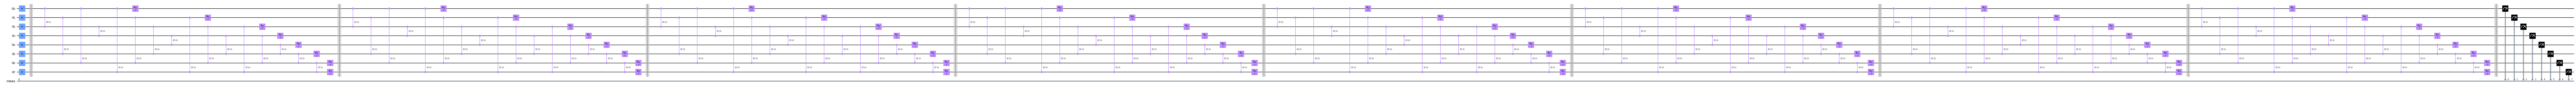

In [12]:
repeat = 8

initial_point = []
for i in range(2*repeat): initial_point.append(1.0)
create_qaoa_circ(G,initial_point).draw(output="mpl", fold=-1)

In [13]:
expectation = get_expectation(G)

res = minimize(expectation, 
                      initial_point, 
                      method='COBYLA')
res

     fun: -8.599609375
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 170
  status: 1
 success: True
       x: array([2.07681263, 1.97917288, 2.01088211, 1.01756931, 1.99736951,
       1.04136982, 1.99481614, 2.06133405, 0.9783245 , 0.98405696,
       1.043396  , 0.99329317, 1.013542  , 1.01660429, 0.99439534,
       1.00765849])

In [14]:
backend = Aer.get_backend('qasm_simulator')
backend.shots = 1024

qc_res = create_qaoa_circ(G, res.x)

counts = backend.run(qc_res, seed_simulator=10).result().get_counts()
sort = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))
print("Top 4 solutions:")
es = 0
for i in sort:
    print('sol:',i,', max cut:',-maxcut_obj(i,G))
    es+=1
    if es == 4: break
# plot_histogram(counts)

expect = []
for i in range(100): expect.append(nx.algorithms.approximation.maxcut.one_exchange(G)[0])
print('\nexpect max cut:', max(expect))

Top 4 solutions:
sol: 11101010 , max cut: 11
sol: 00010101 , max cut: 11
sol: 00110111 , max cut: 8
sol: 10000111 , max cut: 10

expect max cut: 12
